In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd

pd.set_option('display.max_rows', 30)
!date

Thu May 14 21:52:31 PDT 2020


# Checkout population structure around UW

decennial data from: https://ciser.cornell.edu/data/data-archive/census-2010-sf1-download-center/

decennial data codebook: https://cisermgmt.cornell.edu/go/pub/2010SF1/Census_2010_SF1_Technical_Documentation.pdf

shapefiles from: https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-line-file.html, 'web interface'

In [2]:
locs = ['STATE', 'COUNTY', 'TRACT', 'BLKGRP', 'BLOCK']

keep_cols = ['P0010001', 'ZCTA'] + locs

def my_cols(x):
    if x.startswith('P01200'):
        return True
    else:
        return (x in keep_cols)

## pull in age x sex structure

In [3]:
%%time

decennial = pd.read_csv('/home/j/temp/beatrixh/2020_census/wa2010ur1_all_vars.CSV', usecols = my_cols)

CPU times: user 31.6 s, sys: 1.54 s, total: 33.2 s
Wall time: 33.9 s


In [4]:
decennial = decennial[decennial.BLOCK.notna()]

In [5]:
# get a list of all cols needed for geoid
lower_locs = [i.lower() for i in locs]

# convert to strings
decennial[lower_locs] = decennial[locs].astype(float).astype(int).astype(str)
decennial[lower_locs] = decennial[lower_locs].astype(str)

# rearrange loc vars to be strings of uniform length
decennial.county = [('00' + i) if len(i)==1
             else '0' + i if len(i)==2
             else i for i in decennial.county]

decennial.tract = ['0' + i if len(i)==5
            else '00' + i if len(i)==4
            else '000' + i if len(i)==3
            else i for i in decennial.tract]

decennial.block = ['0' + i if len(i)==3
            else '00' + i if len(i)==2
            else '000' + i if len(i)==1
            else i for i in decennial.block]

# add geoid
decennial['geoid'] = decennial['state'] + decennial['county'] + decennial['tract'] + decennial['block']
print(decennial['geoid'].head())

#these should all be length 15:
print(set([len(i) for i in decennial.geoid]))

59    530019502003244
60    530019502003250
61    530019502003251
62    530019502003252
63    530019502003254
Name: geoid, dtype: object
{15}


In [6]:
decennial.columns

Index(['STATE', 'COUNTY', 'TRACT', 'BLKGRP', 'BLOCK', 'P0010001', 'P0120001',
       'P0120002', 'P0120003', 'P0120004', 'P0120005', 'P0120006', 'P0120007',
       'P0120008', 'P0120009', 'P0120010', 'P0120011', 'P0120012', 'P0120013',
       'P0120014', 'P0120015', 'P0120016', 'P0120017', 'P0120018', 'P0120019',
       'P0120020', 'P0120021', 'P0120022', 'P0120023', 'P0120024', 'P0120025',
       'P0120026', 'P0120027', 'P0120028', 'P0120029', 'P0120030', 'P0120031',
       'P0120032', 'P0120033', 'P0120034', 'P0120035', 'P0120036', 'P0120037',
       'P0120038', 'P0120039', 'P0120040', 'P0120041', 'P0120042', 'P0120043',
       'P0120044', 'P0120045', 'P0120046', 'P0120047', 'P0120048', 'P0120049',
       'state', 'county', 'tract', 'blkgrp', 'block', 'geoid'],
      dtype='object')

In [7]:
# subset to king county
decennial = decennial[decennial.COUNTY==33]

## pull in shapefiles

In [8]:
block_shapes = gpd.read_file('/home/j/temp/beatrixh/sim_science/census_GIS/tl_2010_53_tabblock10/tl_2010_53_tabblock10.shp')

In [9]:
block_shapes.head()

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYP10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,53,001,950100,1004,530019501001004,Block 1004,G5040,R,None,None,S,0,477164,+47.2397419,-117.9780911,"POLYGON ((-117.98390 47.23402, -117.98440 47.2..."
1,53,001,950100,1220,530019501001220,Block 1220,G5040,R,None,None,S,950028,0,+47.2132824,-117.9639088,"POLYGON ((-117.96049 47.22108, -117.96047 47.2..."
2,53,001,950100,1226,530019501001226,Block 1226,G5040,R,None,None,S,606144,0,+47.1896716,-117.9620025,"POLYGON ((-117.96031 47.19978, -117.96026 47.1..."
3,53,001,950100,1235,530019501001235,Block 1235,G5040,R,None,None,S,7599,0,+47.0853664,-117.9938390,"POLYGON ((-117.99392 47.08451, -117.99393 47.0..."
4,53,001,950100,1228,530019501001228,Block 1228,G5040,R,None,None,S,3643139,0,+47.1079086,-117.9687545,"POLYGON ((-117.95994 47.09514, -117.96034 47.0..."


In [10]:
# subset to king county
block_shapes = block_shapes[block_shapes.COUNTYFP10=='033']

In [11]:
# cartesian projection
block_shapes = block_shapes.to_crs({'init': 'epsg:3857'})

/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [12]:
# get area
block_shapes['area'] = block_shapes.geometry.area

# convert to km**2
block_shapes.area = block_shapes.area/10**6

In [13]:
# convert key to string for merging

block_shapes.GEOID10 = block_shapes.GEOID10.astype(str)
decennial.geoid = decennial.geoid.astype(str)

## combine area w/ pop counts

In [14]:
decennial = decennial.merge(block_shapes[['GEOID10','area']], left_on = 'geoid', right_on = 'GEOID10', how='left')

In [15]:
decennial.head()

,STATE,COUNTY,TRACT,BLKGRP,BLOCK,P0010001,P0120001,P0120002,P0120003,P0120004,...,P0120048,P0120049,state,county,tract,blkgrp,block,geoid,GEOID10,area
0,53,33.0,31202.0,1.0,1014.0,0,0,0,0,0,...,0,0,53,033,031202,1,1014,530330312021014,530330312021014,0.033603
1,53,33.0,31202.0,1.0,1017.0,309,309,158,7,11,...,1,2,53,033,031202,1,1017,530330312021017,530330312021017,2.149353
2,53,33.0,31202.0,1.0,1018.0,6,6,2,0,0,...,0,0,53,033,031202,1,1018,530330312021018,530330312021018,0.005844
3,53,33.0,31202.0,2.0,2000.0,0,0,0,0,0,...,0,0,53,033,031202,2,2000,530330312022000,530330312022000,0.123027
4,53,33.0,31202.0,2.0,2001.0,97,97,50,0,0,...,0,1,53,033,031202,2,2001,530330312022001,530330312022001,0.268237


In [16]:
decennial['pop_density'] = decennial['P0010001'] / decennial['area']

## rename vars

In [17]:
## var labels

# Total: P0120001 04 9
# Male: P0120002 04 9
# Under 5 years P0120003 04 9
# 5 to 9 years P0120004 04 9
# 10 to 14 years P0120005 04 9
# 15 to 17 years P0120006 04 9
# 18 and 19 years P0120007 04 9
# 20 years P0120008 04 9
# 21 years P0120009 04 9
# 22 to 24 years P0120010 04 9
# 25 to 29 years P0120011 04 9
# 30 to 34 years P0120012 04 9
# 35 to 39 years P0120013 04 9
# 40 to 44 years P0120014 04 9
# 45 to 49 years P0120015 04 9
# 50 to 54 years P0120016 04 9
# 55 to 59 years P0120017 04 9
# 60 and 61 years P0120018 04 9
# 62 to 64 years P0120019 04 9
# 65 and 66 years P0120020 04 9
# 67 to 69 years P0120021 04 9
# 70 to 74 years P0120022 04 9
# 75 to 79 years P0120023 04 9
# 80 to 84 years P0120024 04 9
# 85 years and over P0120025 04 9
# Female: P0120026 04 9
# Under 5 years P0120027 04 9
# 5 to 9 years P0120028 04 9
# 10 to 14 years P0120029 04 9
# 15 to 17 years P0120030 04 9
# 18 and 19 years P0120031 04 9
# 20 years P0120032 04 9
# 21 years P0120033 04 9
# 22 to 24 years P0120034 04 9
# 25 to 29 years P0120035 04 9
# 30 to 34 years P0120036 04 9
# 35 to 39 years P0120037 04 9
# 40 to 44 years P0120038 04 9
# 45 to 49 years P0120039 04 9
# 50 to 54 years P0120040 04 9
# 55 to 59 years P0120041 04 9
# 60 and 61 years P0120042 04 9
# 62 to 64 years P0120043 04 9
# 65 and 66 years P0120044 04 9
# 67 to 69 years P0120045 04 9
# 70 to 74 years P0120046 04 9
# 75 to 79 years P0120047 04 9
# 80 to 84 years P0120048 04 9
# 85 years and over P0120049 04 9

In [18]:
male = ['P012000' + str(i) for i in np.arange(3,10)] + ['P01200' + str(i) for i in np.arange(10,26)]
female = ['P01200' + str(i) for i in np.arange(27,50)]

In [19]:
ages = ['0_4','5_9','10_14','15_17','18_19','20','21','22_24'] + [str(i) + '_' + str(i +4) for i in np.arange(25,56,5)] + ['60_61','62_64','65_66','67_69','70_74','75_79','80_84','85_plus']

In [20]:
male_labs = ['m_' + i for i in ages]
female_labs =  ['f_' + i for i in ages]

In [21]:
renaming = {}
for i in np.arange(len(female)):
    renaming[male[i]] = male_labs[i]
    renaming[female[i]] = female_labs[i]
    
renaming['P0010001'] = 'total_pop'
renaming['P0120002'] = 'm_total'
renaming['P0120026'] = 'f_total'

In [22]:
output = decennial.rename(columns=renaming)

In [23]:
to_drop = locs + ['P0120001','GEOID10'] #duplicates: total pop, geoid
output = output.drop(columns=to_drop)

In [24]:
output.columns

Index(['total_pop', 'm_total', 'm_0_4', 'm_5_9', 'm_10_14', 'm_15_17',
       'm_18_19', 'm_20', 'm_21', 'm_22_24', 'm_25_29', 'm_30_34', 'm_35_39',
       'm_40_44', 'm_45_49', 'm_50_54', 'm_55_59', 'm_60_61', 'm_62_64',
       'm_65_66', 'm_67_69', 'm_70_74', 'm_75_79', 'm_80_84', 'm_85_plus',
       'f_total', 'f_0_4', 'f_5_9', 'f_10_14', 'f_15_17', 'f_18_19', 'f_20',
       'f_21', 'f_22_24', 'f_25_29', 'f_30_34', 'f_35_39', 'f_40_44',
       'f_45_49', 'f_50_54', 'f_55_59', 'f_60_61', 'f_62_64', 'f_65_66',
       'f_67_69', 'f_70_74', 'f_75_79', 'f_80_84', 'f_85_plus', 'state',
       'county', 'tract', 'blkgrp', 'block', 'geoid', 'area', 'pop_density'],
      dtype='object')

In [25]:
output.head()

,total_pop,m_total,m_0_4,m_5_9,m_10_14,m_15_17,m_18_19,m_20,m_21,m_22_24,...,f_80_84,f_85_plus,state,county,tract,blkgrp,block,geoid,area,pop_density
0,0,0,0,0,0,0,0,0,0,0,...,0,0,53,033,031202,1,1014,530330312021014,0.033603,0.000000
1,309,158,7,11,14,16,3,2,2,6,...,1,2,53,033,031202,1,1017,530330312021017,2.149353,143.764175
2,6,2,0,0,0,0,0,0,0,0,...,0,0,53,033,031202,1,1018,530330312021018,0.005844,1026.702491
3,0,0,0,0,0,0,0,0,0,0,...,0,0,53,033,031202,2,2000,530330312022000,0.123027,0.000000
4,97,50,0,0,1,25,13,1,0,0,...,0,1,53,033,031202,2,2001,530330312022001,0.268237,361.620856


In [26]:
output.to_csv('/home/j/Project/simulation_science/covid/data/census_data/2020_05_14_king_county_population_distribution_2010.csv', index = False)

## viz results

In [172]:
viz_dt = block_shapes.to_crs({'init': 'EPSG:4326'})

/share/code/beatrixh/miniconda/envs/gis/lib/python3.6/site-packages/pyproj/crs/crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<function matplotlib.pyplot.show(*args, **kw)>

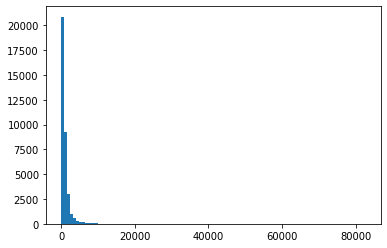

In [173]:
plt.hist(output.pop_density, bins = 100)
plt.show

In [144]:
viz_dt = viz_dt.merge(output[['total_pop','pop_density','geoid']], left_on='GEOID10', right_on = 'geoid', how = 'left')

In [194]:
viz_dt['key'] = viz_dt.GEOID10.astype(int)
output['key'] = output.geoid.astype(int)

In [195]:
viz_dt = viz_dt.sort_values(by='key')
output = output.sort_values(by='key')

In [197]:
viz_dt['pop_density'] = output.pop_density.tolist()

In [198]:
viz_dt['log_pop_density'] = np.log(viz_dt.pop_density + 1)

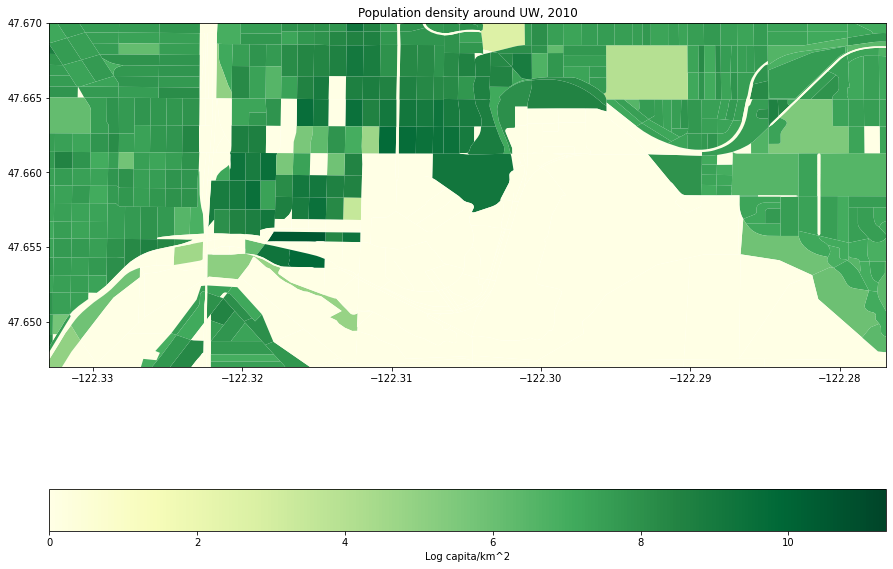

In [206]:
fig, ax = plt.subplots(figsize = (15,15))

ax.set_xlim(-122.332927, -122.276884)
ax.set_ylim(47.647, 47.67)

plt.title('Population density around UW, 2010')

viz_dt.plot(ax=ax, column='log_pop_density', cmap = 'YlGn',
            legend = True,
            legend_kwds={'label': "Log capita/km^2",'orientation': "horizontal"})
plt.show()

In [221]:
## make sure correctly added pop_density col
test = viz_dt.merge(output[['pop_density','geoid']], left_on = 'GEOID10', right_on = 'geoid', how = 'left')
test[test.pop_density_x!=test.pop_density_y]

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYP10,...,geometry,area,test,pls_work,log_pls_work,key,pop_density_x,log_pop_density,pop_density_y,geoid
